<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [9]:
total_len = len(df)

In [10]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [11]:
train_df.shape

(2629, 29)

In [12]:
val_df.shape

(564, 29)

In [13]:
test_df.shape

(564, 29)

# Scaling

In [14]:
scaler_1 = MinMaxScaler()

In [15]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [16]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [17]:
scaler_2 = MinMaxScaler()

In [18]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [19]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [20]:
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

# Create Sequence Data

In [21]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [22]:
LOOKBACK = 60

In [23]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_full, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, y_val_full, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, y_test_full, LOOKBACK)

In [24]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_full, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, y_val_full, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, y_test_full, LOOKBACK)

# Metrics

In [25]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)
  return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [26]:
from itertools import product

In [27]:
GRID = {
    "filters": [32, 64],
    "kernel_size": [3, 5],
    "dilation_depth": [3, 4],
    "learning_rate": [0.001, 0.003],
    "batch_size": [32, 64],
}

grid_combinations = list(product(
    GRID["filters"],
    GRID["kernel_size"],
    GRID["dilation_depth"],
    GRID["learning_rate"],
    GRID["batch_size"],
))

In [28]:
len(grid_combinations)

32

In [29]:
def TCN_block(x, filters, kernel_size, dilation_rate):
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu")(x)
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu")(y)

  if x.shape[-1] != filters:
    x = layers.Conv1D(filters, 1, padding="same")(x)

  return layers.Add()([x, y])

In [30]:
def build_tcn(input_shape, filters, kernel_size, dilation_depth, learning_rate):
  inputs = layers.Input(shape=input_shape)

  x = inputs
  for i in range(dilation_depth):
    x = TCN_block(x, filters=filters, kernel_size=kernel_size, dilation_rate=2 ** i)

  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dense(32, activation="relu")(x)
  outputs = layers.Dense(1)(x)  # Predict 1 day log-return

  model = models.Model(inputs, outputs)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="mse"
  )
  return model

In [31]:
results = []

In [32]:
for i, (filters, kernel_size, depth, lr, batch_size) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"filters={filters}, kernel={kernel_size}, "
        f"dilations={depth}, lr={lr}, batch={batch_size}")

  ## WITHOUT MACRO
  model_1 = build_tcn(
      X_train_1.shape[1:],
      filters,
      kernel_size,
      depth,
      lr
  )

  model_1.fit(
      X_train_1, y_train_1,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_1, y_val_1),
      callbacks = [
          callbacks.EarlyStopping(
              patience=5, restore_best_weights=True
          )
      ],
      verbose=0
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  ## WITH MACRO
  model_2 = build_tcn(
      X_train_2.shape[1:],
      filters,
      kernel_size,
      depth,
      lr
  )

  model_2.fit(
      X_train_2, y_train_2,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_2, y_val_2),
      callbacks = [
          callbacks.EarlyStopping(
              patience=5, restore_best_weights=True
          )
      ],
      verbose = 0
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "filters": filters,
      "kernel_size": kernel_size,
      "dilation_depth": depth,
      "learning_rate": lr,
      "batch_size": batch_size,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/32] filters=32, kernel=3, dilations=3, lr=0.001, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

[2/32] filters=32, kernel=3, dilations=3, lr=0.001, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

[3/32] filters=32, kernel=3, dilations=3, lr=0.003, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

[4/32] filters=32, kernel=3, dilations=3, lr=0.003, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

[5/32] filters=32, kernel=3, dilations=4, lr=0.001, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

[6/32] filters=32, kernel=3, dilations=4, lr=0.001, batch=64
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

[7/32] filters=32, kernel=3, dilations=4, lr=0.003, batch=32
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

[8/32

# Results

In [33]:
results_df = pd.DataFrame(results)

In [34]:
results_df

,filters,kernel_size,dilation_depth,learning_rate,batch_size,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,32,3,3,0.001,32,0.007078,0.008282,0.084128,0.091004,0.077916,0.074114,0.488095,0.488095,False,False,True,False
1,32,3,3,0.001,64,0.000577,0.073486,0.024011,0.271083,0.017546,0.242388,0.525794,0.488095,False,False,False,False
2,32,3,3,0.003,32,0.003275,0.036349,0.057227,0.190653,0.051415,0.171963,0.488095,0.488095,False,False,False,False
3,32,3,3,0.003,64,0.000571,0.009740,0.023887,0.098689,0.017304,0.089845,0.507937,0.488095,False,False,False,False
4,32,3,4,0.001,32,0.002150,0.073635,0.046365,0.271358,0.040222,0.251098,0.488095,0.488095,False,False,False,False
5,32,3,4,0.001,64,0.000589,0.031824,0.024260,0.178394,0.018017,0.155070,0.531746,0.511905,False,False,False,False
6,32,3,4,0.003,32,0.004515,0.007833,0.067194,0.088506,0.061749,0.074205,0.488095,0.511905,False,False,False,True
7,32,3,4,0.003,64,0.000574,0.019436,0.023959,0.139412,0.017513,0.127527,0.507937,0.488095,False,False,False,False
8,32,5,3,0.001,32,0.004272,0.026831,0.065358,0.163803,0.060019,0.146706,0.488095,0.488095,False,False,False,False
9,32,5,3,0.001,64,0.000690,0.008788,0.026270,0.093744,0.020233,0.083129,0.521825,0.488095,False,False,False,False


In [35]:
results_df.to_csv('tcn_grid_results.csv') # Retraining the model is optional

In [36]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [37]:
best_without_macro

,19
filters,64
kernel_size,3
dilation_depth,3
learning_rate,0.003
batch_size,64
MSE_1,0.000569
MSE_2,0.000814
RMSE_1,0.023846
RMSE_2,0.028534
MAE_1,0.017444


In [38]:
best_with_macro

,12
filters,32
kernel_size,5
dilation_depth,4
learning_rate,0.001
batch_size,32
MSE_1,0.002101
MSE_2,0.000774
RMSE_1,0.045833
RMSE_2,0.027813
MAE_1,0.040021


In [39]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [40]:
macro_mse_win_rate

np.float64(0.125)

In [41]:
macro_mae_win_rate

np.float64(0.1875)

In [42]:
macro_da_win_rate

np.float64(0.28125)

# Retrain for Plotting

In [ ]:
def build_tcn(input_shape, filters, kernel_size, dilation_depth, learning_rate):
  inputs = layers.Input(shape=input_shape)

  x = inputs
  for i in range(dilation_depth):
    x = TCN_block(x, filters=filters, kernel_size=kernel_size, dilation_rate=2 ** i)

  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dense(32, activation="relu")(x)
  outputs = layers.Dense(1)(x)  # Predict 1 day log-return

  model = models.Model(inputs, outputs)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="mse"
  )
  return model

In [44]:
model_1 = build_tcn(X_train_1.shape[1:], best_without_macro['filters'], int(best_without_macro['kernel_size']), best_without_macro['dilation_depth'], best_without_macro['learning_rate'])

In [57]:
history_best_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=50,
    batch_size=int(best_without_macro['batch_size']),
    validation_data=(X_val_1, y_val_1),
    callbacks = [
      callbacks.EarlyStopping(
          patience=5, restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0017 - val_loss: 8.6498e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0017 - val_loss: 7.7150e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0017 - val_loss: 6.8574e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0017 - val_loss: 6.5990e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0017 - val_loss: 6.4971e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0017 - val_loss: 6.3544e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0017 - val_loss: 6.5217e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0017 - val_loss: 6.1588e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0017 - val_loss: 6.1746e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0017 - val_loss: 6.3041e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0017 - val_loss: 6.1989e-04
Epoch 12/50
41/41 ━

In [58]:
y_pred_1 = model_1.predict(X_test_1).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [59]:
model_2 = build_tcn(X_train_2.shape[1:], best_with_macro['filters'], int(best_with_macro['kernel_size']), best_with_macro['dilation_depth'], best_with_macro['learning_rate'])

In [61]:
history_best_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=50,
    batch_size=int(best_with_macro['batch_size']),
    validation_data=(X_val_2, y_val_2),
    callbacks = [
      callbacks.EarlyStopping(
          patience=5, restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0018 - val_loss: 8.9260e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0018 - val_loss: 9.6702e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0018 - val_loss: 9.3797e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0018 - val_loss: 8.8970e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0018 - val_loss: 9.8562e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - val_loss: 9.9510e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0018 - val_loss: 9.8381e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0018 - val_loss: 0.0010


In [62]:
y_pred_2 = model_2.predict(X_test_2).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


# Price Reconstruction

In [63]:
actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

In [64]:
prev_actual_prices = test_df["btc_price"].iloc[LOOKBACK-1:-1].values

In [65]:
prev_actual_prices = prev_actual_prices[:len(y_pred_1)]

In [66]:
pred_price_1 = prev_actual_prices * np.exp(y_pred_1[:len(prev_actual_prices)])
pred_price_2 = prev_actual_prices * np.exp(y_pred_2[:len(prev_actual_prices)])

In [67]:
actual_prices = actual_prices[:len(pred_price_1)]

# Plotting

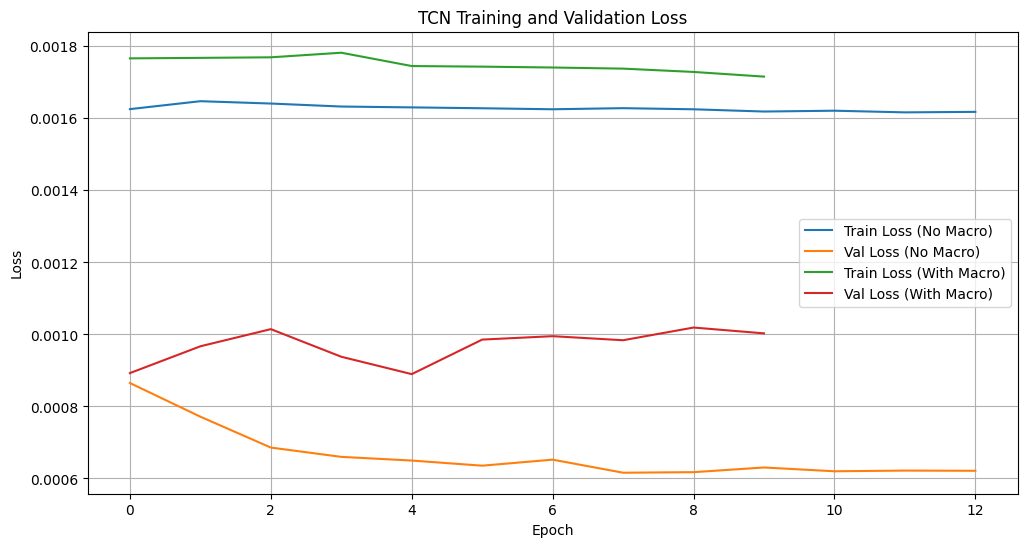

In [68]:
plt.figure(figsize=(12,6))
plt.plot(history_best_without_macro.history["loss"], label="Train Loss (No Macro)")
plt.plot(history_best_without_macro.history["val_loss"], label="Val Loss (No Macro)")
plt.plot(history_best_with_macro.history["loss"], label="Train Loss (With Macro)")
plt.plot(history_best_with_macro.history["val_loss"], label="Val Loss (With Macro)")
plt.title("TCN Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

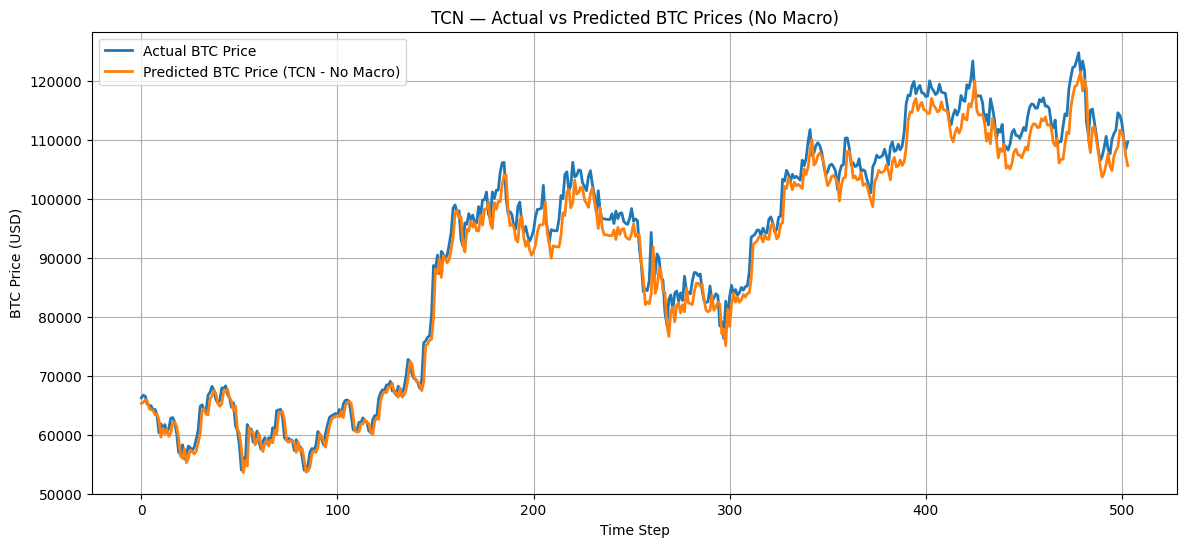

In [69]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_1, label="Predicted BTC Price (TCN - No Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (No Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

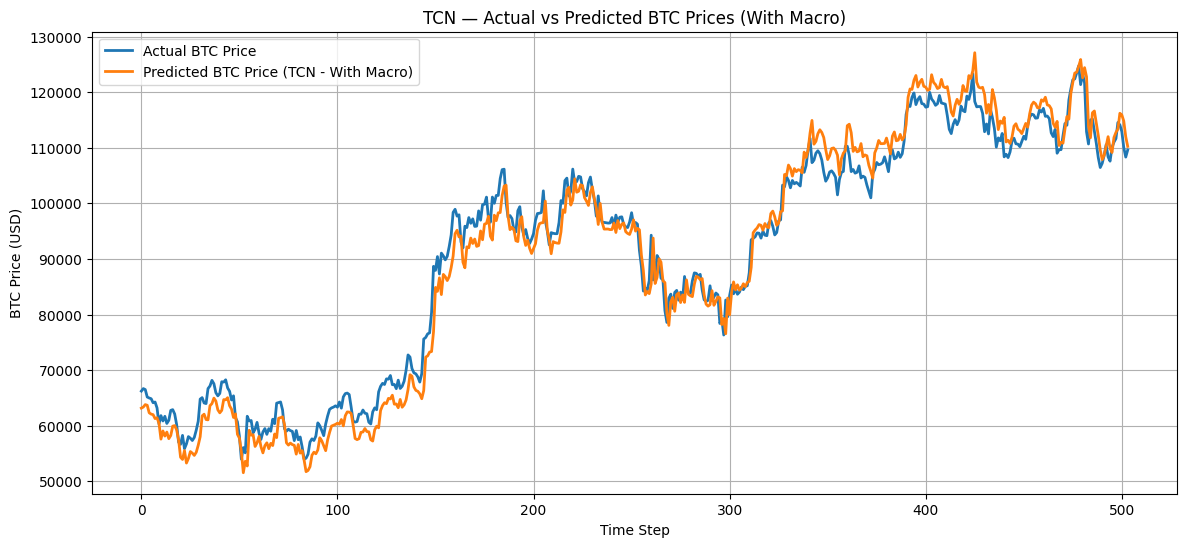

In [70]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_2, label="Predicted BTC Price (TCN - With Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (With Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()